### Introduction


**Probelm Statement:** Make a classifier which takes in a job description and gives the department name for it.
*   Use a neural network model
*   Make use of a pre-trained Word Embeddings (example: Word2Vec, GloVe, etc.)
*   Calculate the accuracy on a test set (data not used to train the model)

**Problem Solving Approach:** 

1. Reading individual JSON file, making a combined object from it then normalizing the JSON object and extract description and ID from it, merging it with the deapartment table. Then, eliminating the rows where there is no description, getting a clean dataframe with id, description and department.  
2. Then doing some EDA, and alinging training dataset(limiting or combining lables), having a look over description of the text associated with individual label with the help of the word cloud.
3. processing the training set for building the model upon it, tokenizing, padding and limiting the description, building word index, linking GLoVe vectors with individual words, one hot encode the lables, finally giving all for training and evaluating the output.

### Part I: Text Preprocessing

_Include all text preprocesing steps like processing of json,csv files & data cleaning in this part._

Import neccessary packages in below cell

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize  

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
json_dir = "data/docs/"

# Taking JSON data from individual file
json_data = []
for file in os.listdir(json_dir):
    content = json.loads(
                open(
                    f"{json_dir}{file}",
                    "r"
                ).read()
            )
    json_data.append(content)

# Converting the json data into a flatten data frame
df = json_normalize(json_data)
df._id = df._id.astype(int)
df = df[["_id","jd_information.description"]]

departments_df = pd.read_csv("data/document_departments.csv")

# Merging the department and job description data frame and
# selecting the column of intrest
merged_df = pd.merge(
    df,
    departments_df,
    left_on="_id",
    right_on="Document ID"
).drop("Document ID", axis=1)\
.rename(columns={"_id":"id",
                 "jd_information.description":"description",
                 "Department":"department"
                })

### Part II: Exploratoty Data Analysis

_Include EDA steps like finding distribution of Departments in this part, you may also use plots for EDA._

In [0]:
merged_df = merged_df[merged_df["description"].str.strip() != ""]

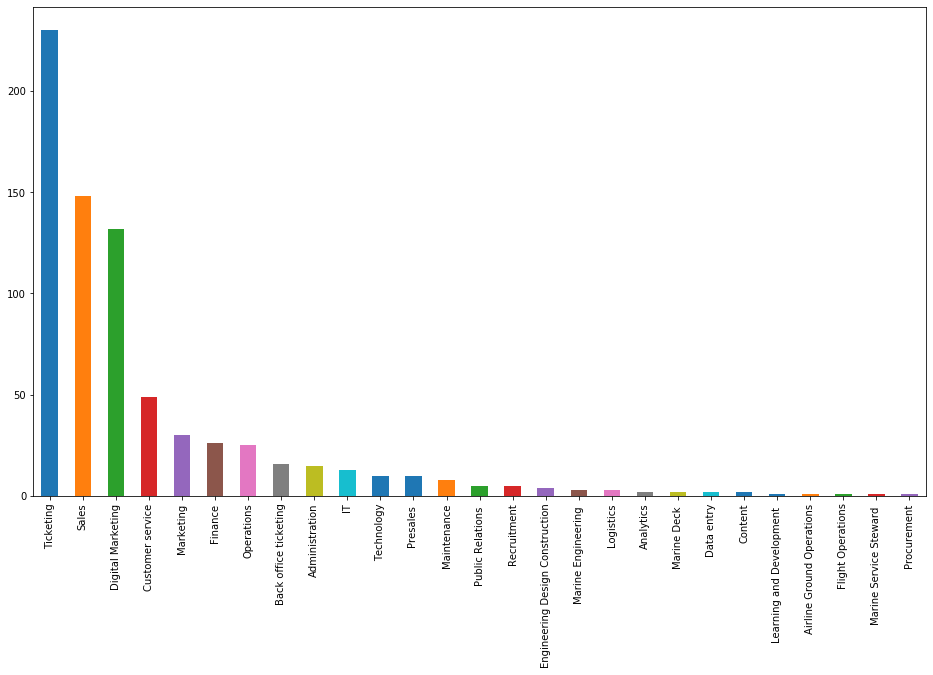

In [4]:
merged_df.department.value_counts().plot("bar")

In [5]:
pd.DataFrame(merged_df.department.value_counts(normalize=True))

,department
Ticketing,0.308725
Sales,0.198658
Digital Marketing,0.177181
Customer service,0.065772
Marketing,0.040268
Finance,0.034899
Operations,0.033557
Back office ticketing,0.021477
Administration,0.020134
IT,0.017450


**Let's eleminate the log tail by naming them as other and consider only top four departments** 

In [0]:
def eleminate_log_tail(label):
    if label not in ["Ticketing","Sales","Digital Marketing","Customer service"]:
        return "Others"
    return label

merged_df.department = merged_df.department.apply(lambda x : eleminate_log_tail(x))

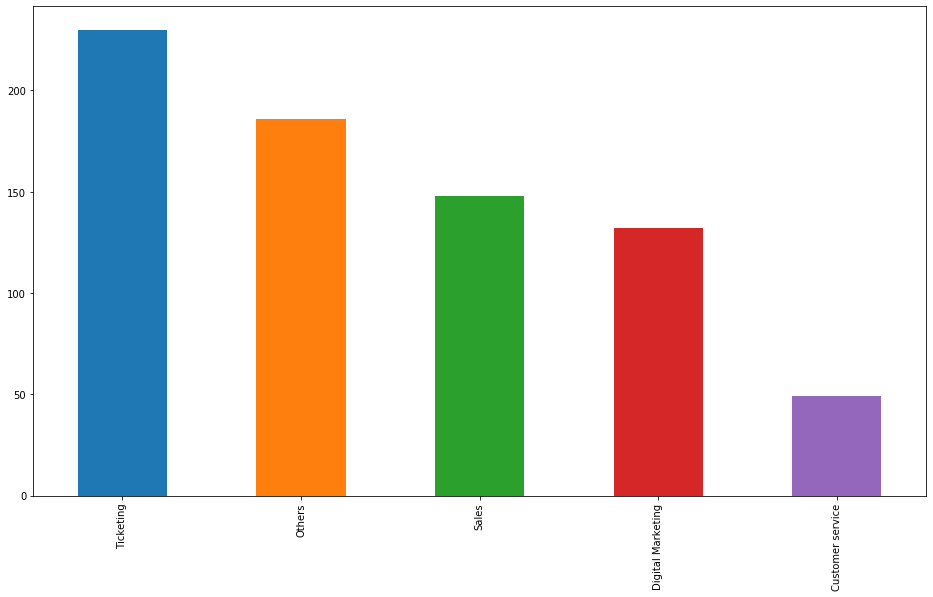

In [7]:
merged_df.department.value_counts().plot("bar")

In [8]:
pd.DataFrame(merged_df.department.value_counts(normalize=True))

,department
Ticketing,0.308725
Others,0.249664
Sales,0.198658
Digital Marketing,0.177181
Customer service,0.065772


**Now Lets see the distribution of the text data**

In [0]:
stopwords = set(STOPWORDS)
stopwords.add("nbsp")
stopwords.add("amp")
def make_cloud(data):
    comment_words = ' '
    for val in data: 
        val = str(val) 
        tokens = val.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words) 
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

**plotting word cloud for description of individual description**

Customer service


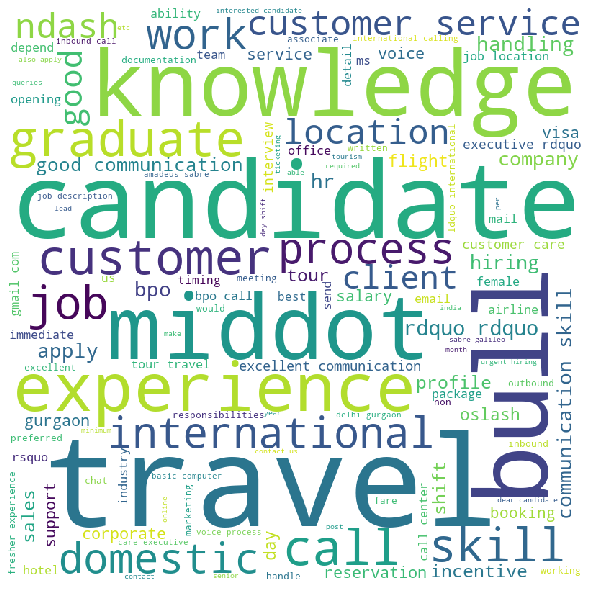

None

____________________________________________________________________________________________________
Digital Marketing


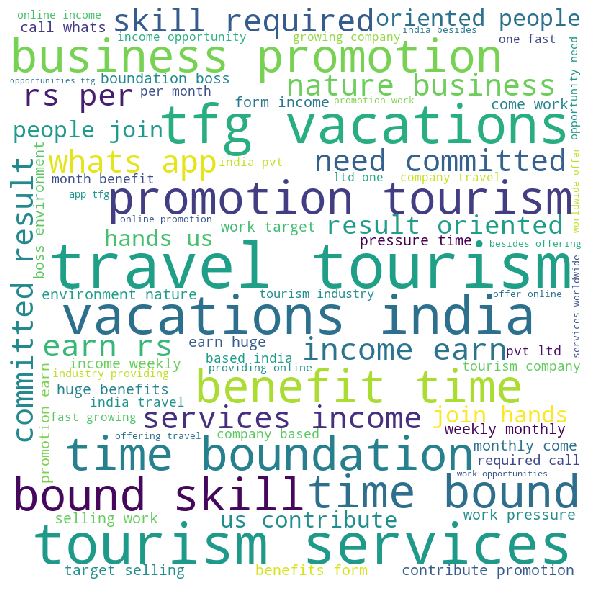

None

____________________________________________________________________________________________________
Others


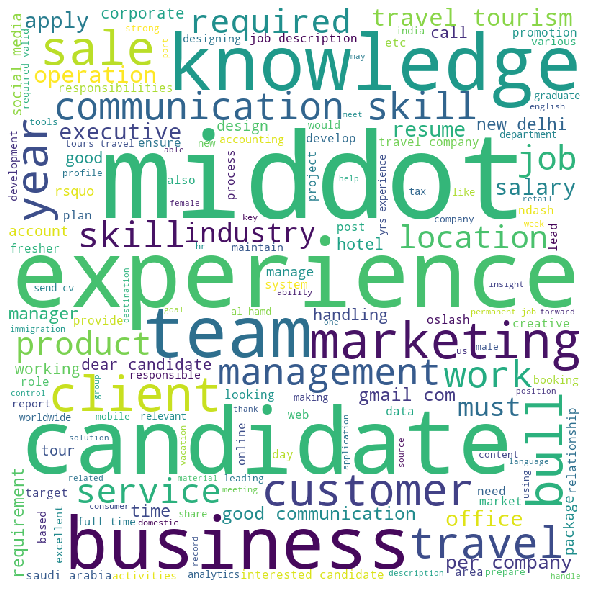

None

____________________________________________________________________________________________________
Sales


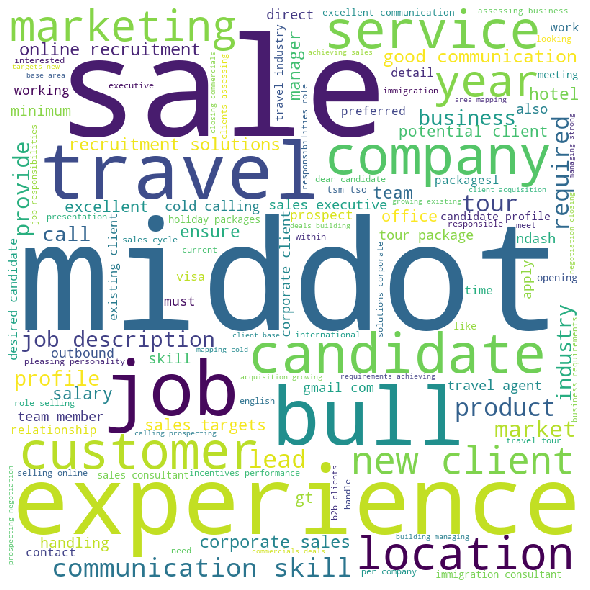

None

____________________________________________________________________________________________________
Ticketing


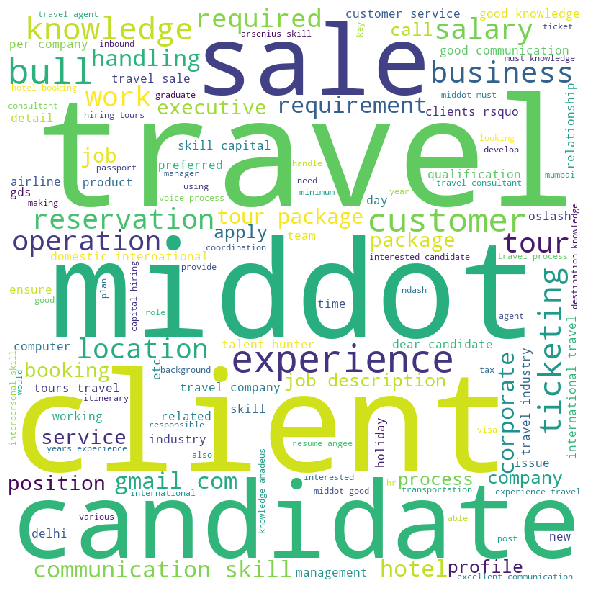

None

____________________________________________________________________________________________________


In [10]:
for department, group in merged_df.groupby("department"):
    print(department)
    display(make_cloud(group.description))
    print("_"*100)

### Part III: Modelling & Evaluation

_Include all model prepration & evaluation steps in this part._

In [0]:
# Getting the glove vectors
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [12]:
embeddings_index = {}
f = open('glove.6B.300d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 6295
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 150
# This is fixed.
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(merged_df["description"].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6295 unique tokens.


In [14]:
X = tokenizer.texts_to_sequences(merged_df["description"].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (745, 150)


In [15]:
Y = pd.get_dummies(merged_df["department"]).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (745, 5)


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(670, 150) (670, 5)
(75, 150) (75, 5)


In [0]:
embedding_dim = 300
embedding_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
  if i < MAX_NB_WORDS:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [19]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          1888500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 2,049,405
Trainable params: 2,049,405
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [21]:
epochs = 20
batch_size = 16

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - 10s 17ms/step - loss: 1.3419 - acc: 0.4312 - val_loss: 1.0910 - val_acc: 0.5522
Epoch 2/20
603/603 [==============================] - 9s 15ms/step - loss: 1.0141 - acc: 0.6169 - val_loss: 0.9345 - val_acc: 0.6269
Epoch 3/20
603/603 [==============================] - 9s 15ms/step - loss: 0.8655 - acc: 0.7081 - val_loss: 0.8555 - val_acc: 0.6866
Epoch 4/20
603/603 [==============================] - 9s 16ms/step - loss: 0.7143 - acc: 0.7529 - val_loss: 0.7953 - val_acc: 0.7015
Epoch 5/20
603/603 [==============================] - 9s 15ms/step - loss: 0.5680 - acc: 0.7977 - val_loss: 0.7561 - val_acc: 0.7015
Epoch 6/20
603/603 [==============================] - 9s 15ms/step - loss: 0.4289 - acc: 0.8640 - val_loss: 0.8213 - val_acc: 0.7164
Epoch 7/20
603/603 [==============================] - 9s 15ms/step - loss: 0.3559 - acc: 0.8856 - val_loss: 0.9631 - val_acc: 0.7015
Epoch 8/20
603/603 [=

In [22]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

75/75 [==============================] - 0s 2ms/step
Test set
  Loss: 1.235
  Accuracy: 0.653


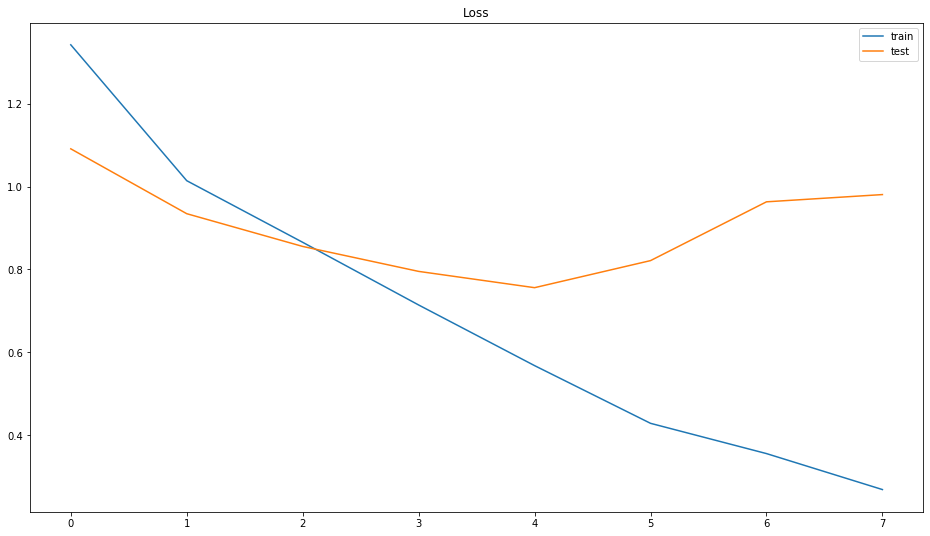

In [23]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

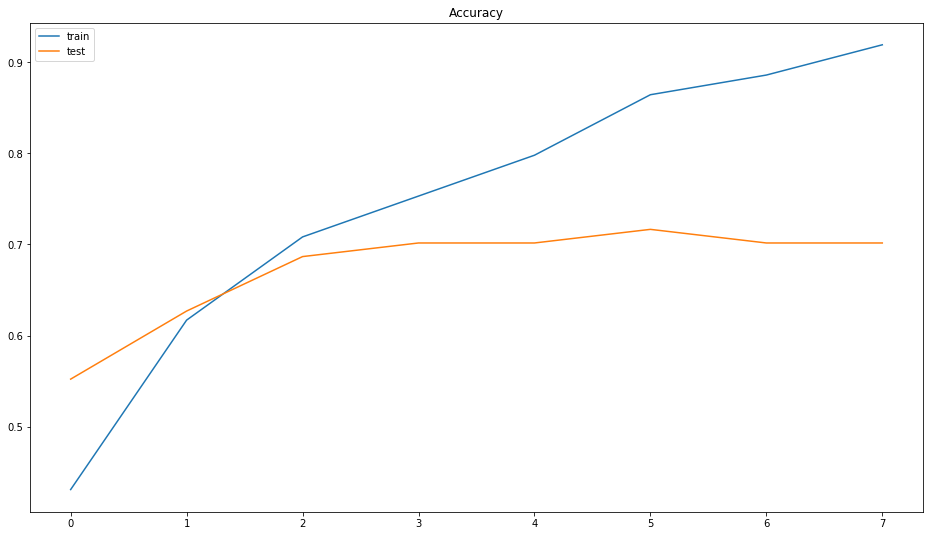

In [24]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

**Results Summary:**

1. After EDA it was found that there was long tail of the departments, so limiting the departments whose contribution in the dataset is more than 5%, for rest making another class called "Others", So finally there were 5 important classes now.
2. From the word cloud build from the description of the individual label, Some relavant terms are seen w.r.t the labels.
3. After training and validating on a dataset of 745 instances the model gave and accuracy of ~65%, which seems to be pretty good for a model trained on such a small data set. Seems like pretrained word embeddings(GLoVe) gave a lot to the description.